## Training a Time Series Model using RNN based Model
In this notebook, we will be using RNN based architecture to train the time series based model using TensorFlow library.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
rain_high_daily = pd.read_csv('rainfall-monthly-highest-daily-total.csv')

In [4]:
rain_high_daily.head()

,month,maximum_rainfall_in_a_day
0,1982-01,36.5
1,1982-02,9.4
2,1982-03,61.7
3,1982-04,45.1
4,1982-05,33.0


In [5]:
rain_high_daily.shape

(462, 2)

In [6]:
requiredData = rain_high_daily.copy()

In [7]:
requiredData.head()

,month,maximum_rainfall_in_a_day
0,1982-01,36.5
1,1982-02,9.4
2,1982-03,61.7
3,1982-04,45.1
4,1982-05,33.0


In [8]:
# Selecting required columns
requiredData.columns = ['Date','rain_fall']

In [9]:
requiredData.head()

,Date,rain_fall
0,1982-01,36.5
1,1982-02,9.4
2,1982-03,61.7
3,1982-04,45.1
4,1982-05,33.0


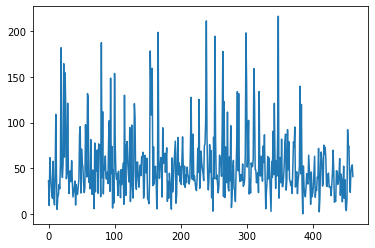

In [10]:
plt.plot(requiredData.rain_fall)
plt.show()

In [11]:
requiredData.shape

(462, 2)

## Data Scaling

In [12]:
# Scaling rainfall data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

In [13]:
sc = MinMaxScaler(feature_range=(0,1))

In [14]:
training_set = requiredData.iloc[:,1:].values

In [15]:
training_set_scaled = sc.fit_transform(training_set)

In [16]:
training_set_scaled[:10]

array([[0.16805556],
       [0.04259259],
       [0.28472222],
       [0.20787037],
       [0.15185185],
       [0.09444444],
       [0.0787037 ],
       [0.2662037 ],
       [0.08240741],
       [0.04537037]])

## Creating training data in required format for RNN Model

In [17]:
X_train = []
y_train = []

In [18]:
training_set_scaled.shape

(462, 1)

In [19]:
# Using past 60 days data to predict 31st day temperature
prev_day = 60
for i in range(prev_day,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-prev_day:i,0])
    y_train.append(training_set_scaled[i,0])

In [20]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
(X_train.shape, y_train.shape)

((402, 60), (402,))

In [22]:
X_train[0], y_train[0]

(array([0.16805556, 0.04259259, 0.28472222, 0.20787037, 0.15185185,
        0.09444444, 0.0787037 , 0.2662037 , 0.08240741, 0.04537037,
        0.18240741, 0.5037037 , 0.19907407, 0.02268519, 0.0837963 ,
        0.09768519, 0.14861111, 0.12731481, 0.25601852, 0.84074074,
        0.23194444, 0.18425926, 0.25277778, 0.76018519, 0.2875    ,
        0.71388889, 0.55185185, 0.17824074, 0.21203704, 0.55972222,
        0.22685185, 0.10324074, 0.21435185, 0.21759259, 0.16296296,
        0.26944444, 0.16342593, 0.08564815, 0.10925926, 0.13472222,
        0.16666667, 0.04490741, 0.14814815, 0.09814815, 0.10092593,
        0.13888889, 0.17592593, 0.40092593, 0.44166667, 0.10555556,
        0.32824074, 0.26018519, 0.23657407, 0.1587963 , 0.10787037,
        0.13055556, 0.45092593, 0.30277778, 0.18657407, 0.6087963 ]),
 0.5888888888888889)

In [23]:
# Reshaping X_train to 3 dimensional array from (402, 60) to (402, 60,1)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(402, 60, 1)


In [24]:
# !pip install tensorflow

### Importing tesorflow library required packages for training

In [25]:
import tensorflow as tf
from tensorflow.keras import Model, layers

In [26]:
# Training Parameters
learning_rate = 0.4
training_steps = X_train.shape[0]
batch_size = 20
display_step = 100

In [27]:
# Using tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((X_train[:380], 
                                y_train[:380]))

train_data = train_data.repeat().shuffle(100).batch(batch_size
                                        ).prefetch(1)

In [28]:
class RNN(Model):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.lstm_layer = layers.LSTM(units=4)
        self.hidden_layer1 = layers.Dense(64)
        self.hidden_layer2 = layers.Dense(128)
        self.dropout1 = layers.Dropout(0.2)
     #   self.dropout2 = layers.Dropout(0.3)
     #   self.dropout3 = layers.Dropout(0.4)
        self.out = layers.Dense(1)
        
    
    def call(self, x):
        
        
        x = self.lstm_layer(x)
        x = self.dropout1(x)

        x = self.dropout1(x)

        x = self.hidden_layer1(x)
      #  x = self.dropout2(x)

     #   x = self.hidden_layer2(x)
     #   x = self.dropout3(x)

        x = self.out(x)
        return x

In [29]:
def loss_func( predicted_y, target_y):
    target_y = tf.dtypes.cast(target_y, tf.double)
    predicted_y = tf.dtypes.cast(predicted_y, tf.double)
    predicted_y = tf.constant(predicted_y)
    target_y = tf.constant(target_y)
    loss = tf.reduce_mean(tf.square(target_y - predicted_y))
    return loss

In [30]:
rnn = RNN()

In [31]:
optimizer = tf.optimizers.Adam(learning_rate)
def train(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = rnn(x)
        # Compute loss.
        loss = loss_func(pred,y)
#         loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = rnn.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update weights following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [32]:
# Run training for the given number of steps.
epoches = 10
for epoch in range(epoches):
    for step, (batch_x, batch_y) in enumerate(train_data.take(480), 1):
        # Run the optimization to update W and b values.
        train(tf.reshape(batch_x,[batch_size,60,1]), batch_y)
        
        if step%100 == 0 or step == 1:
            pred = rnn(tf.reshape(batch_x,[batch_size,60,1]))
            loss = loss_func(pred, batch_y)
            print("Epoch: %i step: %i, loss: %f" % (epoch, step, loss))

Epoch: 0 step: 1, loss: 254.434174
Epoch: 0 step: 100, loss: 0.026275
Epoch: 0 step: 200, loss: 0.015185
Epoch: 0 step: 300, loss: 0.012374
Epoch: 0 step: 400, loss: 0.582201
Epoch: 1 step: 1, loss: 0.127822
Epoch: 1 step: 100, loss: 0.107236
Epoch: 1 step: 200, loss: 0.091066
Epoch: 1 step: 300, loss: 0.039713
Epoch: 1 step: 400, loss: 0.097563
Epoch: 2 step: 1, loss: 0.054435
Epoch: 2 step: 100, loss: 0.020084
Epoch: 2 step: 200, loss: 0.065280
Epoch: 2 step: 300, loss: 0.014697
Epoch: 2 step: 400, loss: 0.047438
Epoch: 3 step: 1, loss: 0.013906
Epoch: 3 step: 100, loss: 0.031989
Epoch: 3 step: 200, loss: 0.015751
Epoch: 3 step: 300, loss: 0.072625
Epoch: 3 step: 400, loss: 0.046693
Epoch: 4 step: 1, loss: 0.023490
Epoch: 4 step: 100, loss: 0.036951
Epoch: 4 step: 200, loss: 0.051448
Epoch: 4 step: 300, loss: 0.016632
Epoch: 4 step: 400, loss: 0.054075
Epoch: 5 step: 1, loss: 0.039678
Epoch: 5 step: 100, loss: 0.018828
Epoch: 5 step: 200, loss: 0.015198
Epoch: 5 step: 300, loss: 0.01

### Creating testing data in the required format for RNN Model

In [33]:
X_test = []
y_test = []

In [34]:
training_set_scaled.shape

(462, 1)

In [35]:
# Using past 60 days data to predict 31st day temp
prev_day = 60
for i in range(380,training_set_scaled.shape[0]):
    X_test.append(training_set_scaled[i-prev_day:i,0])
    y_test.append(training_set_scaled[i,0])

In [36]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [37]:
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().shuffle(100).batch(5).prefetch(1)

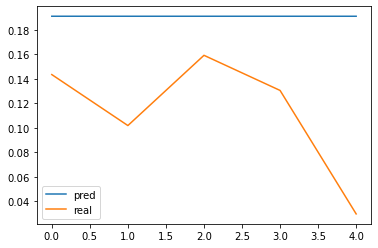

In [38]:
for step, (batch_x, batch_y) in enumerate(test_data.take(1), 1):
    pred = rnn(batch_x)
    plt.plot(pred, label = 'pred')
    plt.plot(batch_y, label = 'real')
    plt.legend()

`Inference: ` The model is not giving best results on the data which is used for training. Further model tuning and refinment is needed.